This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     8256
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2761

Total number of variables............................:     1758
                     variables with only lower bounds:        1
                variables with lower and upper bounds:     1004
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1256
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5000000e+01 3.90e+00 2.47e-07   0.0 0.00e+00    -  0.00e+00 0.00e+00 

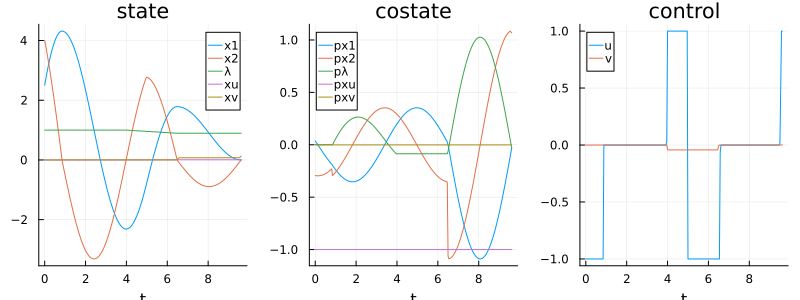

In [6]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures
using LaTeXStrings
using OptimalControl
using NLPModelsIpopt
include("smooth.jl");




a  = 0.0 
ε1 = 0.02
fNC(x) = fNC_unboundedminus(x,a,ε1)
plot(fNC,-1., 1, label="fNC")




@def ocp begin
        
    ε = 1e-3

    tf ∈ R,                          variable

    t ∈ [ 0., tf ],                  time

    q = [ x1, x2, λ, xu, xv ] ∈ R^5, state

    ω = [u, v] ∈ R^2,                control

    tf ≥ 0.
    
    #initial conditions
    x1(0) == 2.5
    x2(0) == 4
    xu(0) == 0
    xv(0) == 0

    #final condition
    x1(tf) == 0
    x2(tf) == 0

    #control constraint
    -1. ≤  u(t)  ≤ 1.

    #state constraint
    -1 ≤  λ(t) ≤ 1,             (1)
    -5 ≤ x1(t) ≤ 5,             (2)
    -5 ≤ x2(t) ≤ 5,             (3)

    #hybrid control system
    q̇(t) == [x2(t), (1-fNC(x2(t)))*u(t) + fNC(x2(t))*λ(t) - x1(t), (1-fNC(x2(t)))*v(t), (v(t))^2, fNC(x2(t))*(u(t))^2]

    #cost function        
    tf + ε*xv(tf) + xu(tf) → min    
end




sol = solve(ocp; init = (state = t -> [0.1, 0.1, 1, 0, 0], control =[-1, 0], variable =15), max_iter=650)



plot(sol; layout=:group, size=(800, 300))


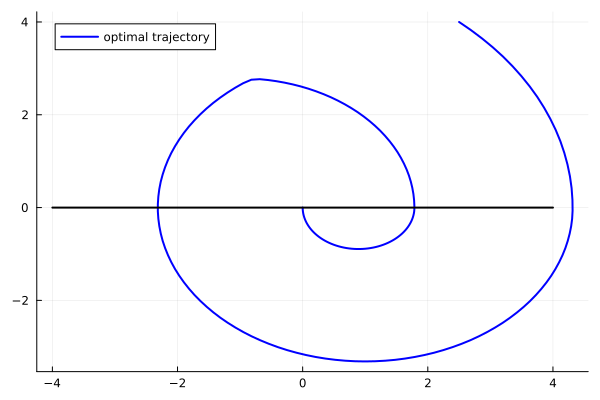

In [8]:
tt    = sol.times
tf    = tt[end] 

x1(t) = sol.state(t)[1]
x2(t) = sol.state(t)[2]
λ(t)  = sol.state(t)[3]
u(t)  = sol.control(t)[1]

# Plot the optimal trajectory
plot(x1, x2, 0, tf, label="optimal trajectory", color="blue", linewidth=2)

# Add vertical lines at x = 5, x = 10, x = 20, x = 25
plot!([-4, 4], [0, 0], color=:black, label=false, linewidth=2)


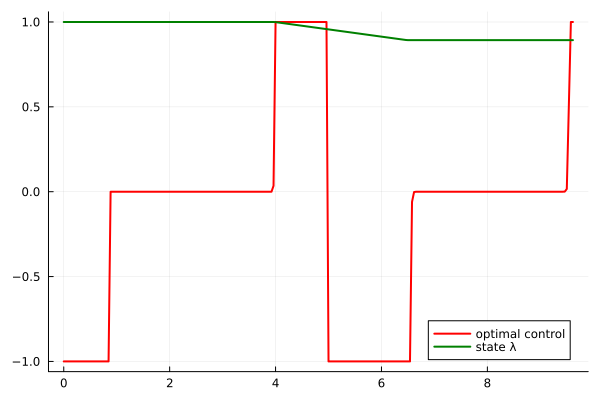

In [9]:
plot(tt, u, label="optimal control", color="red", linewidth=2)
plot!(tt, λ, label="state λ", color="green", linewidth=2)

In [11]:
# Find the crossing times based on conditions for x1
t1_index = findfirst(t -> x2(t) ≤ 0, tt)
t2_index = nothing
t3_index = nothing
t4_index = nothing

# If t1 is found, find the next crossing times
if t1_index !== nothing
    t2_index = findfirst(t -> x2(t) ≥ 0, tt[t1_index+1:end])
    t2_index = t2_index !== nothing ? t2_index + t1_index : nothing
end

if t2_index !== nothing
    t3_index = findfirst(t -> x2(t) ≤ 0, tt[t2_index+1:end])
    t3_index = t3_index !== nothing ? t3_index + t2_index : nothing
end

if t3_index !== nothing
    t4_index = findfirst(t -> x2(t) ≥ 0, tt[t3_index+1:end])
    t4_index = t4_index !== nothing ? t4_index + t3_index : nothing
end

# Convert indices to times
t11 = t1_index !== nothing ? tt[t1_index] : "No such t1 found"
t22 = t2_index !== nothing ? tt[t2_index] : "No such t2 found"
t33 = t3_index !== nothing ? tt[t3_index] : "No such t3 found"
t44 = t4_index !== nothing ? tt[t4_index] : "No such t4 found"

println("First crossing time: ", t11)
println("Second crossing time: ", t22)
println("Third crossing time: ", t33)
println("Fourth crossing time: ", t44)

First crossing time: 0.884628699405235
Second crossing time: 4.00006020600628
Third crossing time: 6.500097834760206
Fourth crossing time: 9.61552934136125
